# Strawberries and Faces ;-)

This is a step by step working example to understand basics image processing function using OpenCV.

It is mostly a bugfix, enhanced wih a few comments, of the original notebook made by Alex Louden and avalable here <https://github.com/alexlouden/strawberries>. I also integrated pieces of code from pyimagesearch <https://www.pyimagesearch.com/2020/04/06/blur-and-anonymize-faces-with-opencv-and-python/>.

In [3]:
%matplotlib inline
import cv2
import matplotlib
from matplotlib import colors
from matplotlib import pyplot as plt
import numpy as np
import os

## Some usefull functions for plotting

As the image has a certain physical resolution when displaying on a bigger frame we need interpolation, we select as default intepolator the nearest neighboor one. To plot an image which is stored in HSV format we need to convert it in RGB first.

In [140]:
def show(image):
    # Figure size in inches
    plt.figure(figsize=(8, 8))
    # Show image, with nearest neighbour interpolation
    plt.imshow(image, interpolation='nearest')
    
def show_hsv(hsv):
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    show(rgb)
    
def show_mask(mask):
    plt.figure(figsize=(8, 8))
    plt.imshow(mask, cmap='gray')
    
def overlay_mask(mask, image):
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.addWeighted(rgb_mask, 0.5, image, 0.5, 0)
    show(img)


### Some constants

In [91]:
test_image_path = './Brain Tumor Data Set/Cancer/Cancer (6).tif'
#image_path = 'strawberries.jpg'

## Image reading and some statistics of pixels

OpenCv knows already how to deal with different image file formats, the only thing you need to keep in mind is that by default it reads the image in memo
ry according to the BGR ordering and not the more commo RGB we are used to.

In [92]:
image = cv2.imread(test_image_path)

In [93]:
print(image.shape)
print("Num pixels:",image.shape[0]*image.shape[1])

(256, 256, 3)
Num pixels: 65536


In [94]:
image[200,200]

array([141, 141, 141], dtype=uint8)

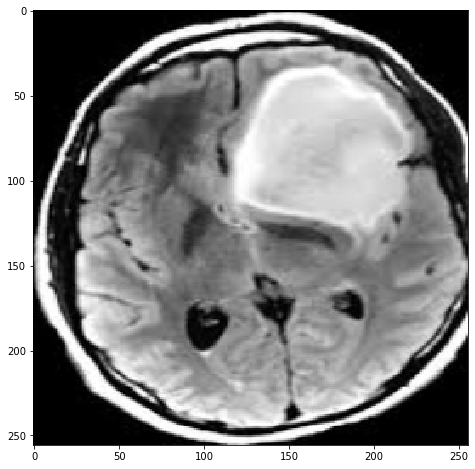

In [97]:
show(image)

In [109]:
# Convert from BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Resize to a third of the size
#image = cv2.resize(image, None, fx=1/3, fy=1/3)

(256, 256, 3)


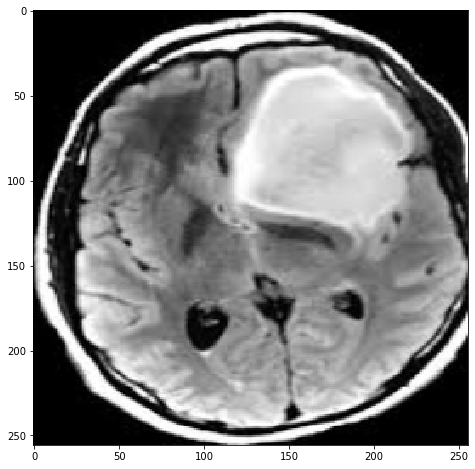

In [110]:
print(image.shape)
show(image)

In [111]:
import pandas as pd
m,n,r = image.shape
arr = image.reshape(m*n, -1) # Equivalent to image.reshape(m*n, 3)
gray_arr = arr[:,0] # Select only a channel (cause it is in gray scale)
print(gray_arr.shape)
df = pd.DataFrame(gray_arr, columns=['gray'])
df.describe()

(65536,)


,gray
count,65536.000000
mean,115.185852
std,81.889879
min,0.000000
25%,24.000000
50%,126.000000
75%,182.000000
max,255.000000


## Channel histograms and color segmentation

Image segmentation is a common practice in Image Analysis and it is about the separation of relevant information from irrelevant one. At pixel level it means to mark strawberry pixels with 1 and non strawberry pixels with 0. 

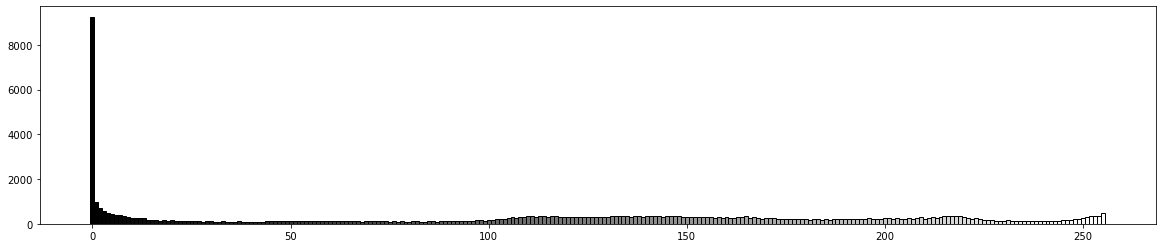

In [117]:
def show_gray_hist(image):
    plt.figure(figsize=(20, 4))
    histr = cv2.calcHist([image], [0], None, [256], [0, 256])

    colours = [((i/256, i/256, i/256)) for i in range(0, 256)]

    plt.bar(range(0, 256), histr[:,0], color=colours, edgecolor=(0,0,0), width=1)

    plt.show()
    
show_gray_hist(image)

# CNN Model

In [43]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout, Dense, InputLayer, Flatten
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam

### Parameters

In [64]:
data_set_path = './Brain Tumor Data Set'
batch_size = 32
img_height = 128
img_width = 128
seed = 42

## Let's load our data

In [65]:
# Training set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_set_path,
  validation_split=0.2,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4514 files belonging to 2 classes.
Using 3612 files for training.


In [66]:
#Validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_set_path,
  validation_split=0.2,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4514 files belonging to 2 classes.
Using 902 files for validation.


In [67]:
class_names = train_ds.class_names
print(class_names)

['Cancer', 'Not cancer']


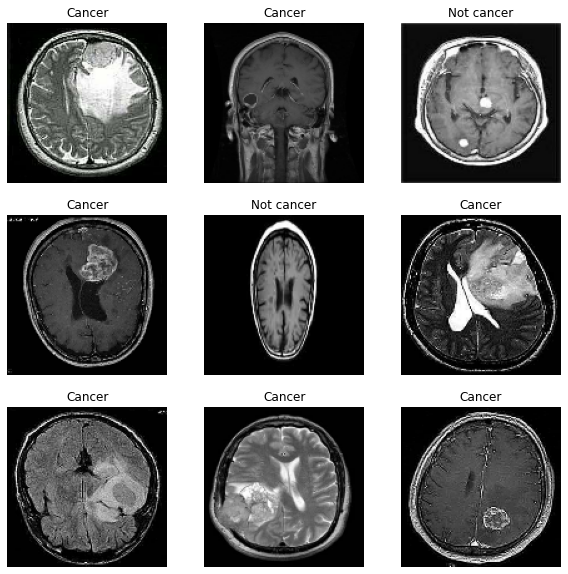

In [69]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Now it's time to train!

In [70]:
# Some optimization settings
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [83]:
# Setup the model pipeline
model = tf.keras.Sequential([
  InputLayer(input_shape=(img_height, img_width, 3)),
  Conv2D(8, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Conv2D(16, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D((2, 2)),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(rate=0.3),
  Dense(64, activation='relu'),
  Dropout(rate=0.3)
  Dense(1, activation="sigmoid")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 63, 63, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 30, 30, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 28, 28, 32)        4640      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 14, 14, 32)      

In [84]:
from keras import utils, callbacks
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", 
                                        patience=5, restore_best_weights = True)

history = model.fit(
    train_ds,
    verbose=1,
    callbacks = [earlystopping],
    epochs=10,
    validation_data=val_ds)

Epoch 1/10
113/113 [==============================] - 17s 148ms/step - loss: 3.5289 - accuracy: 0.7381 - val_loss: 0.3998 - val_accuracy: 0.8271
Epoch 2/10
113/113 [==============================] - 22s 199ms/step - loss: 0.2659 - accuracy: 0.8920 - val_loss: 0.2825 - val_accuracy: 0.8814
Epoch 3/10
113/113 [==============================] - 22s 199ms/step - loss: 0.1463 - accuracy: 0.9488 - val_loss: 0.2373 - val_accuracy: 0.9135
Epoch 4/10
113/113 [==============================] - 23s 200ms/step - loss: 0.1001 - accuracy: 0.9640 - val_loss: 0.1710 - val_accuracy: 0.9313
Epoch 5/10
113/113 [==============================] - 22s 197ms/step - loss: 0.0745 - accuracy: 0.9734 - val_loss: 0.1707 - val_accuracy: 0.9457
Epoch 6/10
113/113 [==============================] - 22s 197ms/step - loss: 0.0446 - accuracy: 0.9839 - val_loss: 0.1133 - val_accuracy: 0.9545
Epoch 7/10
113/113 [==============================] - 22s 197ms/step - loss: 0.0556 - accuracy: 0.9795 - val_loss: 0.2488 - val_ac

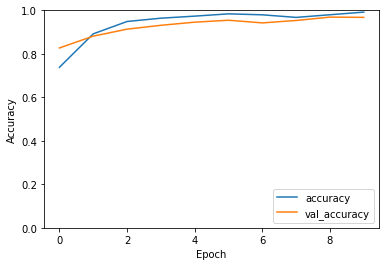

In [85]:
# Plotting accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

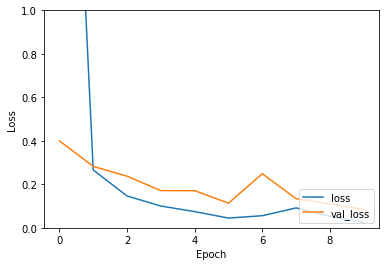

In [86]:
# Plotting loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')

## Let's try our model

In [151]:
#test_image_path = './Brain Tumor Data Set/Not Cancer/Not Cancer  (36).jpg'
#test_image = cv2.imread(test_image_path)
#index_to_test = 3

for images, labels in train_ds.take(1):
  test_image = np.expand_dims(images[index_to_test], 0)
  test_image_class = labels[index_to_test]
  print(labels)

predictions = model.predict(test_image)

print(predictions[0])
print(tf.get_static_value(test_image_class))


tf.Tensor([0 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1], shape=(32,), dtype=int32)
1/1 [==============================] - 0s 24ms/step
[5.32913e-07]
0
